In [63]:
import pandas as pd
import itertools
from itertools import chain
from collections import Counter
from matplotlib import pyplot as plt
import json
import numpy as np

In [44]:
mon = pd.read_csv('AIES-2022-lightning-monday.csv')
tues = pd.read_csv('AIES-2022-lightning-tuesday.csv')
student = pd.read_csv('AIES-2022-student-lightning.csv')

In [45]:
mon_inst = list(filter(lambda x: type(x) != float, chain.from_iterable(mon.loc[:,mon.columns[1:]].values.tolist())))
tues_inst = list(filter(lambda x: type(x) != float, chain.from_iterable(tues.loc[:,tues.columns[1:]].values.tolist())))
student_inst = list(filter(lambda x: type(x) != float, chain.from_iterable(student.loc[:,student.columns[1:]].values.tolist())))

In [46]:
print(len(mon_inst))
print(len(tues_inst))
print(len(student_inst))

44
41
35


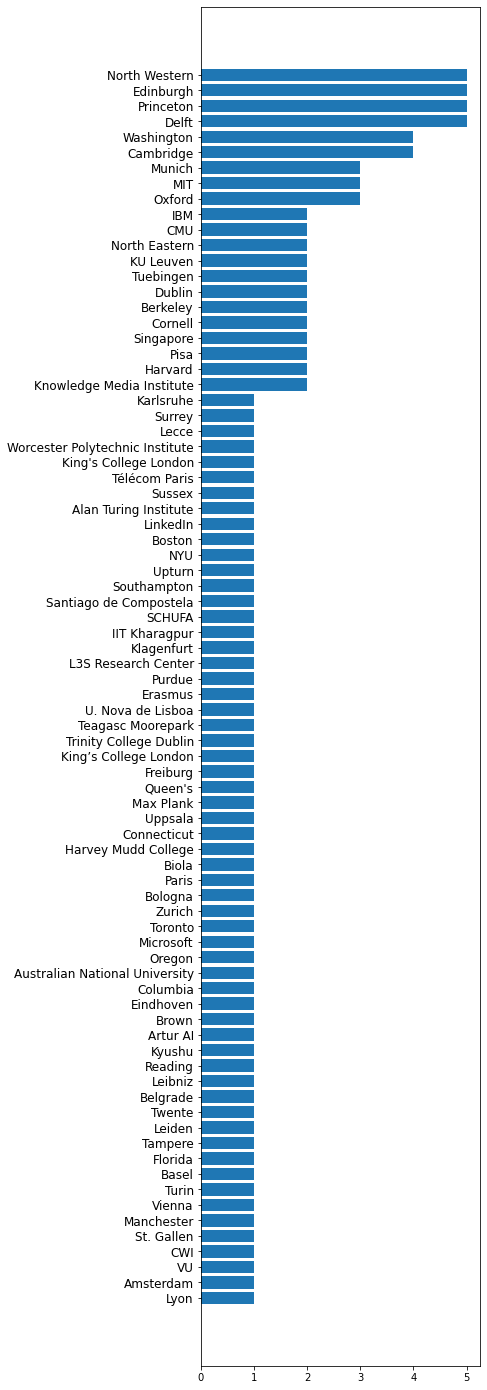

In [47]:
all_lgn = mon_inst + tues_inst + student_inst
orgs, cnts = zip(*Counter(all_lgn).most_common())
plt.figure(figsize=(5, 25))
plt.yticks(fontsize=12)
plt.barh(orgs, cnts)
plt.gca().invert_yaxis()



In [48]:
with open('org_country.json', 'r') as f:
    org_countries = json.load(f)
countries = {}
for country, orgs in org_countries.items():
    cnt = 0
    for org in orgs:
        cnt += all_lgn.count(org)
    countries[country] = cnt


In [49]:
del(countries['Company'])
countries_sorted, cnts_sorted = zip(*sorted(countries.items(), key=lambda item: item[1], reverse=True))

(43, 21, 12, 10, 4, 4, 3, 3, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1)


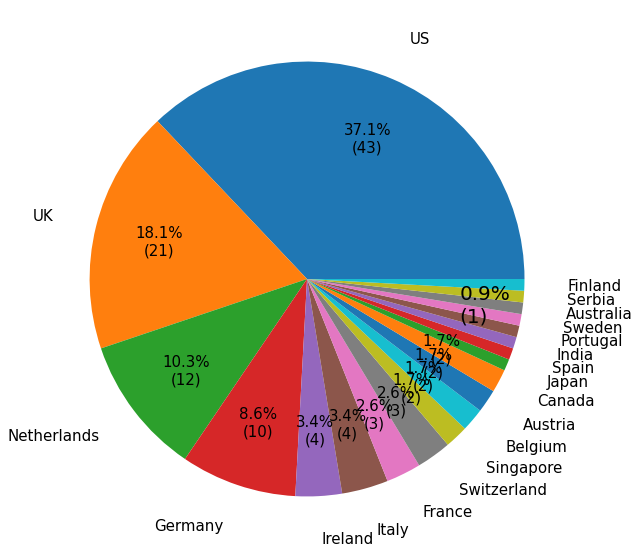

In [95]:
print(cnts_sorted)

def my_autopct(pct, data):
    absolute = int(np.round(pct/100.*np.sum(data)))
    return "{:.1f}%\n({:d})".format(pct, absolute) if pct > 1 else ''

plt.figure(figsize=(10, 10))
plt.text(0.7, -0.2, "{:.1f}%\n({:d})".format(0.9, 1), fontsize=20)
plt.pie(cnts_sorted, 
        labels=countries_sorted, 
        autopct=lambda pct: my_autopct(pct, cnts_sorted), 
        textprops={'fontsize': 15},
        pctdistance=0.7,
        labeldistance=1.2
)
plt.show()
